In [15]:
import os
import random
import warnings

import numpy as np
import pandas as pd
import pyarrow.feather as ft

import matplotlib.pyplot as plt
import seaborn as sns

from utils import get_widget_html, get_multicat_info, MultiCatManager

from tqdm import tqdm
from pprint import pprint

%matplotlib inline
warnings.simplefilter('ignore')

In [16]:
PATH = '../data'

TRAIN_DATA = 'project_train.f'
TEST_DATA = 'project_test_public.f'
OPTION = 'option_names.csv'

TRAIN_PATH = os.path.join(PATH, TRAIN_DATA)
TEST_PATH = os.path.join(PATH, TEST_DATA)
OPTION_PATH = os.path.join(PATH, OPTION)

train_df = ft.read_feather(TRAIN_PATH)
test_df = ft.read_feather(TEST_PATH)
options = pd.read_csv(OPTION_PATH, index_col='id')

In [17]:
train_df.shape, test_df.shape

((1424484, 70), (9780, 66))

In [18]:
train_df.columns.difference(test_df.columns)

Index(['actual_price', 'close_date', 'price', 'start_date'], dtype='object')

Данные содержат очень много колонок, попробуем сгруппировать их

In [19]:
type_dct = {str(k): list(v) for k, v in train_df.groupby(train_df.dtypes, axis=1)}
pprint(type_dct, compact=True)

{'datetime64[ns]': ['start_date', 'close_date', 'sale_end_date'],
 'float64': ['actual_price', 'latitude', 'longitude', 'crashes', 'is_taxi',
             'is_pledged', 'is_restrictions', 'is_carsharing', 'audiosistema',
             'diski', 'electropodemniki', 'fary', 'salon',
             'upravlenie_klimatom', 'usilitel_rul'],
 'int64': ['doors_number', 'year', 'mileage'],
 'object': ['price', 'brand', 'model', 'generation', 'modification',
            'equipment', 'body_type', 'drive_type', 'transmission_type',
            'engine_type', 'color', 'pts', 'owners_count', 'steering_wheel',
            'description', 'Передняя левая фара', 'Передняя правая фара',
            'Правое зеркало', 'Левое зеркало', 'Капот', 'Заднее правое крыло',
            'Заднее левое крыло', 'Передняя левая дверь', 'Крыша',
            'Переднее правое крыло', 'Заднее стекло', 'Задний бампер',
            'Передняя правая дверь', 'Задняя правая фара', 'Дверь багажника',
            'Переднее левое крыл

In [20]:
train_df['price'] = pd.to_numeric(train_df['price'])

In [21]:
def get_info(df: pd.DataFrame):
    info_df = pd.DataFrame(columns=['type', 'n_uniq', 'multi_uniq', 'values', 'null_ratio'], index=df.columns)

    for column in df.columns:
        total = len(df[column])
        null_ratio = df[column].isna().sum() / total
        n_uniq = df[column].nunique()
        uniq = df[column].unique()
        column_type = df[column].dtype
        type_name = ''
        values = '---'
        multi_n_uniq = '---'
        if n_uniq > 100:
            if column in ['latitude', 'longitude']:
                type_name = 'geolocation'
                values = [df[column].min(), df[column].max()]
            elif column_type in ['float64', 'int64']:
                type_name = 'numeric'
                values = [df[column].min(), df[column].max()]
            elif column_type in ['datetime64[ns]']:
                type_name = 'date'
                values = [df[column].min(), df[column].max()]
            elif column in ['description']:
                type_name = 'text'
        if type_name == '' and column_type == 'object':
            multi_uniq = np.unique(sum(map(lambda x: x.strip('[]').split(',') if x else [str(x)], train_df[column].unique()), []))
            multi_n_uniq = len(multi_uniq) - 1
            is_multi = len(uniq) > len(multi_uniq)
            if n_uniq <= 2:
                type_name = 'binary'
                values = uniq
            elif n_uniq <= 10:
                if is_multi:
                    type_name = 'multicategory'
                    values = multi_uniq if multi_n_uniq <= 10 else np.append(multi_uniq[:10], '...')
                else:
                    type_name = 'category'
                    values = uniq
            else:
                if is_multi:
                    type_name = 'multicategory'
                    values = multi_uniq if multi_n_uniq <= 10 else np.append(multi_uniq[:10], '...')
                else:
                    type_name = 'category'
                    values = np.append(uniq[:10], '...')
        if type_name == '':
            if n_uniq <= 2:
                type_name = 'binary'
                values = uniq
            elif n_uniq <= 10:
                type_name = 'category'
                values = uniq
            else:
                type_name = 'category'
                values = np.append(uniq[:10], '...')
        info_df.loc[column] = [type_name, n_uniq, multi_n_uniq, values, null_ratio]
    return info_df

In [22]:
(train_df.brand + train_df.model + train_df.generation).nunique()

1546

In [23]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 1000)
info_df = get_info(train_df)
info_df

type   n_uniq multi_uniq  \
actual_price                        numeric    13964        ---   
price                               numeric    32423        ---   
start_date                             date  1343058        ---   
close_date                             date  1343056        ---   
sale_end_date                          date      240        ---   
brand                              category       76         75   
model                              category      779        778   
generation                         category     1183       1182   
modification                       category     1795       1794   
equipment                          category     1102       1103   
body_type                          category       11         10   
drive_type                         category        3          2   
transmission_type                  category        4          3   
engine_type                        category        5          4   
doors_number                       category        4        ---   
color                              category       17         16   
pts                                category        3          3   
year                               category       72        ---   
mileage                             numeric   198409        ---   
owners_count                       category        4          3   
steering_wheel                       binary        2          1   
latitude                        geolocation     3498        ---   
longitude                       geolocation     3502        ---   
crashes                            category       12        ---   
is_taxi                            category        3        ---   
is_pledged                         category        3        ---   
is_restrictions                    category        3        ---   
is_carsharing                        binary        2        ---   
description                            text  1332870        ---   
Передняя левая фара           multicategory       10          6   
Передняя правая фара          multicategory        9          6   
Правое зеркало                multicategory        8          6   
Левое зеркало                 multicategory        7          6   
Капот                         multicategory       52         10   
Заднее правое крыло           multicategory       49         10   
Заднее левое крыло            multicategory       50         10   
Передняя левая дверь          multicategory       45         10   
Крыша                         multicategory       28         10   
Переднее правое крыло         multicategory       53         10   
Заднее стекло                 multicategory        6          5   
Задний бампер                 multicategory       49         10   
Передняя правая дверь         multicategory       42         10   
Задняя правая фара            multicategory       10          6   
Дверь багажника               multicategory       48         10   
Переднее левое крыло          multicategory       47         10   
Лобовое стекло                multicategory        8          6   
Задняя правая дверь           multicategory       44         10   
Передний бампер               multicategory       58         10   
Задняя левая фара             multicategory        8          6   
Задняя левая дверь            multicategory       38         10   
audiosistema                       category        4        ---   
diski                              category       24        ---   
electropodemniki                     binary        2        ---   
fary                               category        3        ---   
salon                              category        4        ---   
upravlenie_klimatom                category        3        ---   
usilitel_rul                       category        3        ---   
aktivnaya_bezopasnost_mult    multicategory     1458          7   
audiosistema_mult                    binary        1          1   
shini_i_diski_mult 

In [24]:
pd.reset_option('all')

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.

: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



In [25]:
DEALER = ~train_df.actual_price.isna()

In [31]:
train_df['price'] = train_df.price.astype(float)

In [47]:
actual_price_dist = pd.DataFrame(
    {
        'price': train_df.loc[DEALER, 'actual_price'].copy(),
        'price_type': 'dealers'
    }
)

user_price_dist = pd.DataFrame(
    {
        'price': train_df.loc[DEALER, 'price'].copy(),
        'price_type': 'adverts'
    }
)

price_dist = pd.concat([actual_price_dist, user_price_dist], axis=0)

In [49]:
price_dist.dtypes

price         float64
price_type     object
dtype: object

<AxesSubplot:ylabel='Density'>

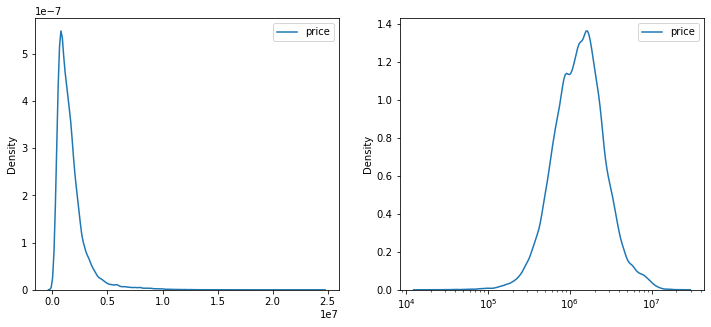

In [50]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.kdeplot(
    data=price_dist,
    log_scale=False,
    ax=ax1
)
sns.kdeplot(
    data=price_dist,
    log_scale=True,
    ax=ax2
)

In [11]:
for_vanya = ['generation', 'modification', 'equipment', 'description', 'audiosistema', 'diski', 'electropodemniki', 'fary', 'salon', 'upravlenie_klimatom', 'usilitel_rul',  'audiosistema_mult', 'shini_i_diski_mult']
for_sasha = info_df[info_df.type == 'multicategory'].index.to_list()
for_maxim = info_df.index.difference(for_vanya).difference(for_sasha).to_list()
for_dict = {'Ваня': for_vanya, 'Саша': for_sasha, 'Максим': for_maxim}

In [12]:
pprint(for_dict, compact=True)

{'Ваня': ['generation', 'modification', 'equipment', 'description',
          'audiosistema', 'diski', 'electropodemniki', 'fary', 'salon',
          'upravlenie_klimatom', 'usilitel_rul', 'audiosistema_mult',
          'shini_i_diski_mult'],
 'Максим': ['actual_price', 'body_type', 'brand', 'close_date', 'color',
            'crashes', 'doors_number', 'drive_type', 'engine_type',
            'is_carsharing', 'is_pledged', 'is_restrictions', 'is_taxi',
            'latitude', 'longitude', 'mileage', 'model', 'owners_count',
            'price', 'pts', 'sale_end_date', 'start_date', 'steering_wheel',
            'transmission_type', 'year'],
 'Саша': ['Передняя левая фара', 'Передняя правая фара', 'Правое зеркало',
          'Левое зеркало', 'Капот', 'Заднее правое крыло', 'Заднее левое крыло',
          'Передняя левая дверь', 'Крыша', 'Переднее правое крыло',
          'Заднее стекло', 'Задний бампер', 'Передняя правая дверь',
          'Задняя правая фара', 'Дверь багажника', 'Передн

Колонки с типом **datetime64[ns]**:
- 'start_date' - дата открытия объявления
- 'close_date' - дата закрытия объявления
- 'sale_end_date' - дата продажи авто дилером

In [13]:
funcs = [min, max, lambda x: x.max() - x.min(), 'count', lambda x: x.count() / len(x)]
train_df[['start_date', 'close_date', 'sale_end_date']].agg(funcs).set_index(pd.Index(['start date', 'end date', 'range', 'count', 'ratio']))

start_date                  close_date  \
start date  2022-02-28 12:34:52.658711  2022-02-28 13:01:38.549945   
end date    2023-02-27 23:33:21.435794  2023-02-28 00:41:28.522994   
range         364 days 10:58:28.777083    364 days 11:39:49.973049   
count                          1343058                     1343058   
ratio                         0.942838                    0.942838   

                  sale_end_date  
start date  2022-06-11 00:00:00  
end date    2023-02-05 00:00:00  
range         239 days 00:00:00  
count                     81426  
ratio                  0.057162

In [14]:
train_df[['start_date', 'close_date', 'sale_end_date']].notnull().apply(lambda x: (x[0] & x[1]) | x[2], axis=1).all()

True

Все строки либо относятся к объявлениям, либо к продажам дилеров.

Разделим train_df на данные дилеров и объявления.

In [15]:
is_dealer = train_df['sale_end_date'].notnull()

dealer_df = train_df[is_dealer]
advert_df = train_df[~is_dealer]

In [16]:
dealer_df.shape, advert_df.shape

((81426, 70), (1343058, 70))

In [17]:
dealer_df.columns[dealer_df.nunique(dropna=False).eq(1)]

Index(['start_date', 'close_date', 'Заднее стекло'], dtype='object')

In [18]:
advert_df.columns[advert_df.nunique(dropna=False).eq(1)]

Index(['actual_price', 'sale_end_date', 'crashes', 'is_taxi', 'is_pledged',
       'is_restrictions', 'is_carsharing'],
      dtype='object')

In [19]:
damage_features = ['Передняя левая фара', 'Передняя правая фара', 'Правое зеркало',
          'Левое зеркало', 'Капот', 'Заднее правое крыло', 'Заднее левое крыло',
          'Передняя левая дверь', 'Крыша', 'Переднее правое крыло',
          'Заднее стекло', 'Задний бампер', 'Передняя правая дверь',
          'Задняя правая фара', 'Дверь багажника', 'Переднее левое крыло',
          'Лобовое стекло', 'Задняя правая дверь', 'Передний бампер',
          'Задняя левая фара', 'Задняя левая дверь']

component_features = ['aktivnaya_bezopasnost_mult', 'electroprivod_mult', 'fary_mult',
          'multimedia_navigacia_mult', 'obogrev_mult', 'pamyat_nastroek_mult',
          'podushki_bezopasnosti_mult', 'pomosh_pri_vozhdenii_mult',
          'protivoygonnaya_sistema_mult', 'salon_mult',
          'upravlenie_klimatom_mult']

In [20]:
df_names = ['train_df', 'dealer_df', 'advert_df', 'test_df']
df_list = [train_df, dealer_df, advert_df, test_df]

df_dict = {k:v for k,v in zip(df_names, df_list)}

In [21]:
damage_index = ['any damage', 'mean if damaged', 'max if damaged']
damage_info = pd.DataFrame(columns=df_names, index=damage_index)
damage_info.loc['any damage'] = [df[damage_features].notna().any(axis=1).sum() for df in df_list]
damage_info.loc['mean if damaged'] = [df[damage_features].notna().sum(axis=1).replace(0, np.nan).mean() for df in df_list]
damage_info.loc['max if damaged'] = [df[damage_features].notna().sum(axis=1).max() for df in df_list]

In [22]:
damage_info

train_df dealer_df advert_df test_df
any damage          72461       243     72218      16
mean if damaged  2.137729  1.979424  2.138262  1.9375
max if damaged         21         8        21       5

In [23]:
damage_manager = MultiCatManager(train_df, test_df, damage_features, 'damage_features')
damage_manager.build()

In [24]:
damage_stats = pd.DataFrame(index=damage_features)
for name, df in df_dict.items():
    print(name)
    damage_stats[name] = damage_manager.get_entropy(df)
    temp_mask = df[damage_features].notna().any(axis=1)
    damage_stats[f'{name}_damaged'] = damage_manager.get_entropy(df[temp_mask])

train_df
dealer_df
advert_df
test_df


In [25]:
damage_stats.loc['Total'] = damage_stats.sum()

In [26]:
damage_stats.style.highlight_quantile(q_left=0.75)

In [27]:
damage_r2 = pd.DataFrame(data={'price_r2_all': damage_manager.get_variance(dealer_df, 'actual_price'), 'price_r2_damaged': damage_manager.get_variance(dealer_df[dealer_df[damage_features].notna().any(axis=1)], 'actual_price')}, index=damage_features)

In [28]:
damage_r2

price_r2_all  price_r2_damaged
Передняя левая фара    9.092138e-06          0.001458
Передняя правая фара   8.625697e-08          0.001193
Правое зеркало         1.527829e-05          0.006077
Левое зеркало          2.078488e-05          0.004678
Капот                  4.179459e-05          0.001694
Заднее правое крыло    1.265851e-04          0.020686
Заднее левое крыло     1.018716e-04          0.009266
Передняя левая дверь   1.012055e-04          0.017064
Крыша                  2.669680e-06          0.002228
Переднее правое крыло  9.338772e-05          0.023766
Заднее стекло          0.000000e+00          0.000000
Задний бампер          1.202304e-04          0.010876
Передняя правая дверь  9.663647e-05          0.016991
Задняя правая фара     1.800945e-05          0.005233
Дверь багажника        1.595842e-04          0.023274
Переднее левое крыло   7.629252e-05          0.008915
Лобовое стекло         2.038041e-05          0.039781
Задняя правая дверь    1.119348e-04          0.013143
Передний бампер        1.686870e-04          0.006089
Задняя левая фара      1.440320e-05          0.002430
Задняя левая дверь     8.322264e-05          0.029973

In [29]:
component_manager = MultiCatManager(train_df, test_df, component_features, 'component_features')
component_manager.build()

In [30]:
component_stats = pd.DataFrame(index=component_features)
for name, df in df_dict.items():
    print(name)
    component_stats[name] = component_manager.get_entropy(df)
    temp_mask = df[damage_features].notna().any(axis=1)
    component_stats[f'{name}_damaged'] = component_manager.get_entropy(df[temp_mask])

train_df
dealer_df
advert_df
test_df


In [31]:
component_stats.style.highlight_quantile(q_left=0.75)

In [32]:
component_r2 = pd.DataFrame(data={'price_r2': component_manager.get_variance(dealer_df, 'actual_price')}, index=component_features)

In [33]:
component_r2

price_r2
aktivnaya_bezopasnost_mult    0.169772
electroprivod_mult            0.273463
fary_mult                     0.129816
multimedia_navigacia_mult     0.260520
obogrev_mult                  0.182345
pamyat_nastroek_mult          0.216239
podushki_bezopasnosti_mult    0.145560
pomosh_pri_vozhdenii_mult     0.314791
protivoygonnaya_sistema_mult  0.019680
salon_mult                    0.058965
upravlenie_klimatom_mult      0.002986

In [34]:
get_widget_html('damage_features', damage_features, train_df, dealer_df, advert_df, test_df, options)

In [35]:
get_widget_html('component_features', component_features, train_df, dealer_df, advert_df, test_df, options)

In [36]:
get_multicat_info(train_df['protivoygonnaya_sistema_mult'].unique(), 'protivoygonnaya_sistema_mult', dfs=df_list, names=df_names, options=options)

train_df  \
                                                   percentage   
Сигнализация                                           6.2133   
Центральный замок                                      9.7555   
Иммобилайзер                                           0.6528   
Спутник                                                0.1012   
None                                                  43.3574   
Сигнализация, Центральный замок                       10.9717   
Сигнализация, Иммобилайзер                             0.6421   
Центральный замок, Иммобилайзер                        8.5199   
Сигнализация, Спутник                                  0.2372   
Центральный замок, Спутник                             0.1268   
Иммобилайзер, Спутник                                  0.0195   
Сигнализация, Центральный замок, Иммобилайзер         15.3769   
Сигнализация, Центральный замок, Спутник               0.4952   
Сигнализация, Иммобилайзер, Спутник                    0.0627   
Центральный замок, Иммобилайзер, Спутник               0.2192   
Сигнализация, Центральный замок, Иммобилайзер, ...     3.2485   

                                                                     \
                                                   multi percentage   
Сигнализация                                                37.2477   
Центральный замок                                           48.7137   
Иммобилайзер                                                28.7416   
Спутник                                                      4.5103   
None                                                        43.3574   
Сигнализация, Центральный замок                             30.0924   
Сигнализация, Иммобилайзер                                  19.3303   
Центральный замок, Иммобилайзер                             27.3645   
Сигнализация, Спутник                                        4.0436   
Центральный замок, Спутник                                   4.0897   
Иммобилайзер, Спутник                                        3.5499   
Сигнализация, Центральный замок, Иммобилайзер               18.6255   
Сигнализация, Центральный замок, Спутник                     3.7437   
Сигнализация, Иммобилайзер, Спутник                          3.3112   
Центральный замок, Иммобилайзер, Спутник                     3.4677   
Сигнализация, Центральный замок, Иммобилайзер, ...           3.2485   

                                                    dealer_df  \
                                                   percentage   
Сигнализация                                           1.3141   
Центральный замок                                     12.2995   
Иммобилайзер                                           1.1286   
Спутник                                                0.0086   
None                                                  23.9948   
Сигнализация, Центральный замок                        4.7638   
Сигнализация, Иммобилайзер                             0.5219   
Центральный замок, Иммобилайзер                       28.4909   
Сигнализация, Спутник                                  0.0111   
Центральный замок, Спутник                             0.0086   
Иммобилайзер, Спутник                                  0.0037   
Сигнализация, Центральный замок, Иммобилайзер          27.108   
Сигнализация, Центральный замок, Спутник               0.0356   
Сигнализация, Иммобилайзер, Спутник                    0.0049   
Центральный замок, Иммобилайзер, Спутник               0.0184   
Сигнализация, Центральный замок, Иммобилайзер, ...     0.2874   

                                                                     \
                                                   multi percentage   
Сигнализация                                                34.0469   
Центральный замок                                           73.0123   
Иммобилайзер                                                57.5639   
Спутник                                                      0.3783   
None  

In [37]:
# from dataprep.eda import plot, plot_correlation, plot_missing, plot_diff, create_report

# create_report(dealer_df.drop(['start_date', 'close_date', 'Заднее стекло'], axis=1), progress=False).save('report_dealer_df.html')